# Chinese Syllable Count Generator Working Draft Notes
*Designed, constructed, and documented by Jeff Heller, Data and Project Coordinator for the Department of East Asian Studies, Princeton University.*

*With expertise and assistance from fellow Princetonians:*

*Anna Shields, Professor of East Asian Studies*

*Joshua Seufert, Chinese Studies Librarian, The East Asian Library and the Gest Collection*

*Thomas Ventimiglia, Technical Support Specialist, The East Asian Library and the Gest Collection*

*Matthew Lee '22*

This document details the process of experimentation related to the construction of the Chinese Syllable Count Generator function. The function takes romanized Chinese text of any size or word count, evaluates the number of syllables based on the supplied Latin characters, and outputs a list of integers representing the syllables of each identified word.

The initial stages of development tests three methods of storing data for optimized processing comparison: Python list, NumPy Array, and Pandas DataFrame.

Structured systems are the basis of Chinese romanization with accepted combinations of "initials" (the initial sound of a syllable, e.g., the first consonant) and "finals" (the ending sound of a syllable, e.g., vowels that sometimes end with a consonant). For example, one syllable in pinyin can be as small as one letter and as large as six letters. Therefore, detecting a syllable can occur in one of two ways:
1. A sequence of letters compared to a list of accepted pinyin syllables. If the sequence appears in the list, or if the sequence is part of a longer accepted term ("tia" by itself is not an accepted syllable, however "tiao" and "tian" are), then an additional letter from the pinyin can be added to the sequence and reevaluated. If the sequence does not appear in the list and is not part of a longer accepted term, then the last character of the sequence becomes the first character of the next syllable, and the syllable count incremented.
2. A sequence of letters is processed incrementally with the initials identified first, and then the finals after the appearance of the first vowel. The identified initial and final values act as indexes to a table (either a NumPy Array or Pandas DataFrame) of boolean values that evaluate the initial and final pairing. If the table returns False, then the final is compared to a list of other final values to determine whether it can be part of a more extended final. If it is, then the function continues onto the next incremented letter. Otherwise, the function determines that the current letter is the start of the next syllable and increments the number of syllables for that word.

Given these possibilities, two metrics need to be considered to settle on the proper method for the evaluation function: speed and size. I hypothesize that comparing a sequence of letters to a list of terms can be faster; however, the list itself may be excessively large. Evaluating sequences by their combination of initials and finals, however, may take longer but results in a much smaller package. The following exercises test each method on a smaller scale to get a general sense of the speed vs. size issue.

## Setup for Testing

The code below imports two CSV files. The first contains the list of acceptable pinyin syllables (e.g. "yang," "wei"). The second contains an array of 1 values with a column header of initials and row headers with finals. Empty values convert to 0, and both 1 and 0 values convert to the boolean values True and False, respectively in their array and DataFrame forms.

In [112]:
import csv
import sys

import numpy as np
import pandas as pd

## LIST ##
# Import list of all pinyin combinations
smList = []
with open("data/pinyinList.csv") as f:
    r = csv.reader(f)
    for row in r:
        smList += row

## NUMPY/DATAFRAME ##
# List of initials, finals for Numpy evaluation
PY = np.genfromtxt("data/pinyinDF.csv", delimiter=",", dtype=str)
initList = list(PY[1:, 0])
finList = list(PY[0, 1:])

# Import Numpy array from CSV
smAr = PY[1:, 1:] == "1"

# Import dataframe from CSV
smDF = (
    pd.read_csv("data/pinyinDF.csv", header=0,
                index_col=0, dtype={"INDEX": str})
    .fillna(0)
    .astype("bool")
)

# Print examples of each form of reference data.
print("Python List:")
print(str(smList[0:30]))
print("Displaying 30 of " + str(len(smList)) +
      " possible pinyin combinations " + "\n")
print("——————————————————\n")
print("# Header lists for use in indexing the array/DataFrame")
print("Initials List:")
print(initList)
print("Finals List:")
print(str(finList) + "\n")
print("——————————————————\n")
print("Numpy Array:")
print(str(smAr[0]))
print("Displaying 1 of " + str(len(smAr)) + " rows within the array" + "\n")
print("Pandas DataFrame:")
print(smDF.head(3))


Python List:
['a', 'ai', 'ao', 'an', 'ang', 'e', 'ei', 'en', 'eng', 'er', 'o', 'ou', 'yi', 'ya', 'yao', 'ye', 'you', 'yan', 'yang', 'yin', 'ying', 'yong', 'wu', 'wa', 'wo', 'wei', 'wai', 'wan', 'wen', 'wang']
Displaying 30 of 407 possible pinyin combinations 

——————————————————

# Header lists for use in indexing the array/DataFrame
Initials List:
['ø', 'b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'z', 'c', 's', 'zh', 'ch', 'sh', 'r', 'j', 'q', 'x', 'g', 'k', 'h', 'y', 'w']
Finals List:
['a', 'ai', 'ao', 'an', 'ang', 'e', 'ei', 'en', 'eng', 'er', 'o', 'ong', 'ou', 'i', 'ia', 'iao', 'ie', 'iu', 'ian', 'iang', 'in', 'ing', 'iong', 'u', 'ua', 'uo', 'ue', 'ui', 'uai', 'uan', 'uang', 'un', 'v', 've']

——————————————————

Numpy Array:
[ True  True  True  True  True  True  True  True  True  True  True False
  True False False False False False False False False False False False
 False False False False False False False False False False]
Displaying 1 of 24 rows within the array

Pandas DataFram

## Performing the Tests
To best compare the size and performance speed of each method this test works with two examples: a small two-letter phrase that is an acceptable pinyin term ("ba"), and a longer five-letter term that is not an acceptable pinyin term ("quang"). The %timeit function measures processing time with each method after running 100,000 iterations.

### Methods
1. The Python "in" function: the script searches through the list of acceptable pinyin terms for the supplied example.
2. The examples split into their initial and final pairs, their indexes derived from within the list of initials and finals, and those values are then used to find the appropriate boolean within the NumPy Array.
3. A Pandas DataFrame houses the boolean values, and three Pandas-specific methods are used to slice it:
    1. Traditional slicing method (to be deprecated in future versions): "exampleDF[initial][final]"
    2. The .loc method: "exampleDF.loc[initial][final]"
    3. The .iloc method: "exampleDF.iloc[index of initial within list of initials][index of final within list of finals]"

In [58]:
# Variables used for testing
smEval1 = "ba"
smInitial1 = "b"
smFinal1 = "a"

smEval2 = "quang"
smInitial2 = "q"
smFinal2 = "uang"


# Subject 1: Short, acceptable term
print('# Results of "ba" (short, valid):')

# Method 1: Python List
print("Python List: " + str(sys.getsizeof(smList)))
%timeit -n 100000 smEval1 in smList

# Method 2: Numpy Array
print(
    "\nNumpy array: "
    + str(sys.getsizeof(initList) + sys.getsizeof(finList) + sys.getsizeof(smAr))
    + ", without initials and finals lists: "
    + str(sys.getsizeof(smAr))
)
%timeit -n 100000 smAr[initList.index(smInitial1), finList.index(smFinal1)] != True

# Method 3: Pandas DataFrame
# 3a: slice
print("\nDataFrame: " + str(sys.getsizeof(smDF)))
print("slice")
%timeit -n 100000 smDF[smFinal1][smInitial1] != True

# 3b: loc
print("loc")
%timeit -n 100000 smDF.loc[smInitial1, smFinal1] != True

print("iloc")
# 3c: iloc
%timeit -n 100000 smDF.iloc[initList.index(smInitial1), finList.index(smFinal1)] != True


# Subject 2: Longer, unacceptable term
print('\n\n# Results of "quang" (longer, invalid):')

# Method 1: Python List
print("Python List: " + str(sys.getsizeof(smList)))
%timeit -n 100000 smEval2 in smList

# Method 2: Numpy Array
print(
    "\nNumpy array: "
    + str(sys.getsizeof(initList) + sys.getsizeof(finList) + sys.getsizeof(smAr))
    + ", without initials and finals lists: "
    + str(sys.getsizeof(smAr))
)
%timeit -n 100000 smAr[initList.index(smInitial2), finList.index(smFinal2)] != True

# Method 3: Pandas DataFrame
# 3a: slice
print("\nDataFrame: " + str(sys.getsizeof(smDF)))
print("slice")
%timeit -n 100000 smDF[smFinal2][smInitial2] != True

# 3b: loc
print("loc")
%timeit -n 100000 smDF.loc[smInitial2, smFinal2] != True

print("iloc")
# 3c: iloc
%timeit -n 100000 smDF.iloc[initList.index(smInitial2), finList.index(smFinal2)] != True

# Results of "ba" (short, valid):
Python List: 3760
438 ns ± 24.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numpy array: 1672, without initials and finals lists: 928
1.38 µs ± 39.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

DataFrame: 2427
slice
10.1 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
loc
8.04 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
iloc
8.9 µs ± 32.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Results of "quang" (longer, invalid):
Python List: 3760
4.02 µs ± 49.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Numpy array: 1672, without initials and finals lists: 928
1.94 µs ± 24.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

DataFrame: 3067
slice
10.1 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
loc
7.98 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
iloc
9.77 µs ± 132 ns per loop (mean ± std

## Comparison: Size
The Pandas DataFrame would initially be the smallest form of a boolean table (2.427kb). However, it becomes 25% larger when reaccessed for multiple inquiries due to being loaded into its self-maintained cache (3.067kb). The NumPy array, in addition to the necessary initials and finals lists, takes more space than the initial size of the DataFrame but maintains a small size after repeated uses (2.6kb). The Python list, as expected, takes up the most amount of space due to its listing every possible syllable (3.76kb). Therefore, the NumPy array is the best option assuming the function evaluates multiple queries.

## Comparison: Speed
As expected, there is little difference in speed between the NumPy array evaluating the smaller, acceptable syllable and the larger, unacceptable syllable, with only a 0.55-microsecond difference between them. The Pandas DataFrame performed just as consistently, with an average of a 0.28-microsecond difference between the smaller and larger syllables. However, the DataFrame speed as a whole was impractically slower, with an average of 8.17 microseconds per 100,000 iterations, compared to 1.51 microseconds for the NumPy array.

The Python list resulted in the most significant disparity in time with a 3.28-microsecond difference between the smaller and larger syllables. However, the incredibly quick .399 microsecond result for the smaller, acceptable phrase initially made the option the most attractive for use. Having to search an entire list when supplied an invalid syllable is the disadvantage, leading to its 3.68-microsecond result. Future calculations finding the average length of syllables in practical Chinese use could dictate the real average time of the Python list option, but—assuming that the statistical mean suffices for optimizing this function—the 2.04-microsecond average does not beat that of the NumPy array. Therefore, the array is the best method for this function.

# The sylCount function
With the NumPy array chosen as the index method for acceptable vs. unacceptable syllables, the sylCount function evaluates the inputted text character-by-character. Computational processes benefit from the consistent syllable structure of the Chinese language because—with very few exceptions—most syllables begin with consonants as their initial and vowels as their final (e.g. "chou:" "ch" as initial, "ou" as final). Therefore, an automated process can quickly establish the initial until it encounters a vowel, accessing the array afterward to determine whether the combination of initial and final is valid.

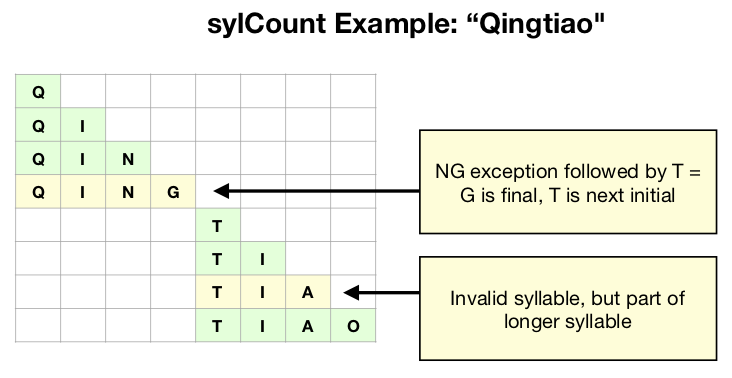

In [1]:
from IPython.display import Image
Image('img/EvaluationExample.png', width=400)

The validity of syllables is an essential step in the function because not only will it determine whether the current sequence of letters counts as a syllable, but also if the syllable is still valid with additional letters added to it. For example, "tiao." The character-by-character loop within the function sets the initial to "t," and then on its next iteration identifies "i" as the final. "Ti," in itself, is a valid syllable. However, the following character "a" results in "tia," which is not a valid syllable. Searching the array is crucial at this stage because "tiao" is an acceptable syllable, but only if detected during the "tia" evaluation. If no other possibilities exist when evaluating a sequence, then it is safe to assume the current syllable has ended.

There are exceptions to this rule, specifically with the possibility of consonants appearing in the final, e.g., "qing." In the pinyin standard, "n," "ng," and "r" (only after following an "e") are all possible consonants in the final. The function, accordingly, must include the ability to evaluate these occurrences and assess whether they are finals, initials, or a combination of both in the case of "ng." Thankfully, these occurrences can be broken down into consistent patterns that are easy to translate into Python.

## The *n* logic
The tables below illustrate the logic behind the evaluation of *n*. Because *n* can appear as initial or final, the first and most straightforward approach to identifying its pattern is to look at each possible scenario for any character in pinyin. One character can have nine total possibilities in its placement, depending on whether there is a vowel, consonant, or nothing preceding it, and a vowel, consonant or nothing succeeding it. According to the table, *n* is only an exception when there is a vowel preceding or succeeding it. All other possibilities are grammatically erroneous, especially if there is a preceding consonant.

In [28]:
from IPython.display import HTML, display
display(HTML("<table style='background-color:black;'><tr><td><img src='img/pinyinPairs.005.png'></td><td><img src='img/pinyinPairs.006.png'></td></tr></table>"))

,


These tables also indicate how the function processes valid possibilities. In the case of *n* with a preceding and succeeding vowel, the syllable count increments by one to account for it being the start of the next syllable. Identifying the character as initial or final is crucial for the function to evaluate the next character correctly.

## The *ng* logic

In [41]:
from IPython.display import HTML, display
display(HTML("<table style='background-color:black;'><tr><td><img src='img/pinyinPairs.003.png'></td><td><img src='img/pinyinPairs.004.png'></td></tr></table>"))

,


For *ng*, the logic is more explicit. The function only identifies the ng pair if there is a preceding vowel since all other possibilities are grammatically incorrect. Also, because *g* is assumed to be the current character in evaluation, the function can quickly identify whether it is the initial of a new syllable or the end of the final based on whether a vowel succeeds it.

## The *er* logic

In [42]:
from IPython.display import HTML, display
display(HTML("<table style='background-color:black;'><tr><td><img src='img/pinyinPairs.001.png'></td><td><img src='img/pinyinPairs.002.png'></td></tr></table>"))

,


The *er* pair has much greater complexity because all nine possibilities are grammatically correct. However, patterns emerge when analyzing their usage in pinyin. If er precedes any character, then the syllable count increments by one to account for the additional syllable. The count also increments by one if er—preceded by a vowel—is succeeded by anything except a vowel. Identifying the current character *r* as initial or final is a simple matter of evaluating whether the succeeding character is a vowel or not.

## Initial Setup

### 1. Package Dependencies
Import necessary packages for function

In [72]:
import numpy as np
import sys
import csv
import re

### 2. Reference Data
List of pinyin initials, finals for Numpy evaluation

In [73]:
PY = np.genfromtxt('data/pinyinDF.csv', delimiter=',', dtype=str)
initPYList = list(PY[1:, 0])
finPYList = list(PY[0, 1:])

# List of Wade-Giles initials, finals
WG = np.genfromtxt('data/wadegilesDF.csv', delimiter=',', dtype=str)
initWGList = list(WG[1:, 0])
finWGList = list(WG[0, 1:])

# Import Numpy arrays from CSV
arPY = PY[1:, 1:] == '1'
arWG = WG[1:, 1:] == '1'

### 3. Reference Variables
Lists/array for reference for easy editing and upgrading

In [74]:
vowel = ['a', 'e', 'i', 'o',
         'u', 'ü', 'v', 'ê', 'ŭ']  # for detecting switch from initial to final

replSym = {'—': '-',
           '–': '-',
           '\'': '’',
           '\u3000': ' '}  # for replacing known invalid characters

### 4. Helper Functions

In [75]:
# 4a. Lists/array for text evaluation
def set_dictionary(wg, crumbs):
    '''Initialize array variables for syllable lookup.'''
    if not wg:
        crumbs_report(crumbs, 'Pinyin system loaded')
        return initPYList, finPYList, arPY
    else:
        crumbs_report(crumbs, 'Wade-Giles system loaded')
        return initWGList, finWGList, arWG

# 4b. Off-loaded, common processes
def crumbs_report(crumbs, status):
    '''Report analyzation steps to the user.'''
    if crumbs:
        print(status)

### 5. Validation Functions

In [76]:
# 5a. Individual validation steps
def CBDB_check(text, CBDB):
    '''CBDB testing purposes ONLY: if the family name is duplicated in the given name'''
    if CBDB and len(text.split()) > 1:
        dupTest = text.split()
        dupTestLen = [len(dupTest[0]), len(dupTest[1])]
        # If the beginning of the given name appears in the family name...
        return (dupTest[0] == dupTest[1][0:dupTestLen[0]] and
            # ...and the given name is longer than the family name (not equal or less)...
            dupTestLen[1] > dupTestLen[0] and
            # ...and it's not just an apostrophe (Wen Wen’chang)...
            dupTest[1][len(dupTest[0])] != "’")
            # ...then the family name has been duplicated
    
def invalid_chars(text):
    '''Check for invalid characters after known invalid characters have been replaced.'''
    evalText = text
    for i, n in replSym.items():
        evalText = evalText.replace(n, '')
    return evalText.isalpha()

def replace_chars(text):
    '''Replace known invalid characters for standardization.'''
    text = text.strip().lower()
    for i, n in replSym.items():
        text = text.replace(i, n)
        text = re.sub(r'\s{2,}', ' ', text)
    return text
    
# 5b. Main validation function
def validate_text(text, CBDB):
    '''Run text through initial steps to prevent evaluation errors.'''
    result = [text]
    if text is np.nan:
        result.append('Error: null value')
        return result
    else:
        result[0] = replace_chars(text)
        
    if not invalid_chars(result[0]):
        result.append('Error: invalid characters detected (' + text + ')')
    
    if CBDB_check(text, CBDB):
        result.append('Error: duplicate family name in given name')

    return result

## Pinyin/Wade-Giles Converter

### Converter Functions

In [77]:
PYWG = {}

with open("data/PYWG.csv") as f:
    r = csv.reader(f)
    PYWG = {rows[0]:rows[1] for rows in r}

## Character Evaluation

### 1. Special Characters (e.g., hyphen, apostrophe, spaces)

In [78]:
def special_characters(n, wg, final):
    '''Accessed when current character is non-alpha.'''
    newSyl = False
    errorMsg = ''
    notes = '[new '
    if n == ' ':
        notes += 'word] space'
    else:
        notes += 'syl] '
        if n == '-':
            notes += 'hyphen'
        elif n == '’' and not wg:
            if final:
                notes += 'pinyin apostrophe'
            else:
                errorMsg = 'Error: possible Wade-Giles apostrophe'
    newSyl = True
    return newSyl, notes, errorMsg

### 2. Finals

In [79]:
def syllable_validation(initial, final, initList, finList, ar):
    '''Determine syllable validity by accessing array with initial/final pair.'''
    return ar[initList.index(initial), finList.index(final)]

In [80]:
def final_evaluation(text, i, n, initial, final, initList, finList, ar):
    '''Detect invalid finals to be separated later.'''
    newSyl = False
    errorMsg = ''
    notes = '[fin] '
    
    # Exception handling
    if n == 'n' or n == 'g':
        try:
            char = text[i + 1]
        except:
            notes += n + ' final detected --> '
        else:
            if char in vowel:
                newSyl = True
                notes += n + 'initial detected --> '
    
    # If no exceptions, attempt to access the array with initial/final pair
    try:
        result = syllable_validation(initial, final + n, initList, finList, ar)
        notes += ('array lookup ' + initial + final + n +
                      ': ' + str(result))
        # Assuming it fails (because of invalid final), the result is false
    except:
        result = False
        notes += 'array error'

    # When false, check if initial/final pair is part of a longer syllable
    if not result:
        # Gather list of finals that start with currently identified final
        listFins = list(i for i in finList if i.startswith(final + n))
        # Attempt to find longer syllables
        try:
            arbool = (not listFins or
                      not any(i for i in listFins if
                              syllable_validation(initial, i, initList, finList, ar))
                     )
        except:
            errorMsg = ('Error: \"' + initial + final + n +
                        '\" invalid final')
        else:
            if arbool:  # It isn't!
                if final[-1] + n == 'er':
                    newSyl = True
                    notes += ' \"er\" ending'
                else:
                    try:
                        char = text[i + 1]
                        if char == ' ':
                            raise ValueError('Error: end of word')
                    except:
                        errorMsg = 'Error: invalid syllable at end of word'
                    else:
                        newSyl = True
                        notes += ' new syl'
            else:  # It is.
                notes += ' definitely more'
    final += n

    return newSyl, notes, final, errorMsg

### 3. Initials

In [81]:
def initial_evaluation(n, initial, final, initList):
    '''Identify character as an initial or final when no final is currently set.'''
    errorMsg = ''
    notes = '[init] '
    
    # If character is not a vowel
    if n not in vowel:

        # Check if character is, or is part of, a valid initial
        if not any(i for i in initList if i.startswith(initial + n)):
            errorMsg = ('Error: \"' + initial + n +
                        '\" invalid initial')
        initial += n
        if n == '’':
            notes += 'apostrophe'
        else:
            notes += 'consonant'

    # Then the vowel is the first character of the final if there's no initial
    else:
        if not initial:
            initial = 'ø'
            notes += 'null initial'
        else:
            notes += 'vowel'
        final = n

    return notes, initial, final, errorMsg

## Syllable Count Evaluation

In [82]:
def new_syllable(syl, sylAdd, i, n, text, initial, final, wg, crumbs):
    '''Obtain syllable count based on evaluated characters.'''
    if n == ' ':
        sylAdd.append(syl)
        syl = 1
        initial = ''
        final = ''
        
    else:
        syl += 1
        if (not wg and n == 'r' or
            wg and n == 'h'):
            if final[-2:] == 'er':
                try:
                    char = text[i+1]
                except:
                    #return syl, sylAdd, initial, final
                    char = ''
                    if initial != 'ø':
                        crumbs_report(crumbs, '\"er\" false positive corrected')
                        syl -= 1
                if char in vowel:
                    initial = n
                    final = ''
                elif len(final) > 2:
                    syl += 1
                    initial = ''
                    final = ''
                    crumbs_report(crumbs, '\"er\" final found')
            else:
                initial = n
                final = ''
        else:
            if n in replSym.values():
                initial = ''
                final = ''
            elif n in vowel:
                initial = 'ø'
                final = n
            else:
                initial = n
                final = ''

    crumbs_report(crumbs, '* syllables counted: ' + str(syl))
    return syl, sylAdd, initial, final

## Main Structure

In [83]:
# sylCount definition with parameters:
# crumbs: show breadcrumbs of NumPy evaluation
# errorReport: return error messages as strings, NaN for non-errors
# CBDB: detect duplication of family name within given name
# wg: evaluate in Wade-Giles standard


def sylCount(text, crumbs=False, errorReport=False, CBDB=False,
             wg=False, method=False, convert=False, skipCount=False,
             skipError=False, itr=''):
    '''Return the number of Chinese characters based on inputted romanized text
    (amongst other things).'''
    
    initList, finList, ar = set_dictionary(wg, crumbs)

    validationResult = validate_text(text, CBDB)
    
    if len(validationResult) > 1:
        errorMsg = validationResult[1]
        crumbs_report(crumbs, errorMsg)
        text = ''
    else:
        text = validationResult[0]


    ## MAIN EVALUATION VARIABLES ##
    # Variables used for evaluation
    initial = ''
    final = ''
    newSyl = False
    syl = 1
    sylAdd = []

    crumbs_report(crumbs, '# Testing ' + text + ' #')

    ## MAIN EVALUATION ##
    # Cycle through each character in text
    for i, n in enumerate(text):

        ## SPECIAL CHARACTERS ##
        if not n.isalpha() and not (n == '’' and wg):
            newSyl, notes, errorMsg = special_characters(n, wg, final)
            crumbStep = initial + '|' + final + n

        ## FINALS ##
        # If final has already been set, regardless of current character
        elif final:
            newSyl, notes, final, errorMsg = (
                final_evaluation(text, i, n, initial, final, initList, finList, ar))
            crumbStep = initial + '|' + final

        ## INITIALS ##
        # If there is no final set (then must be initial)
        else:
            notes, initial, final, errorMsg = (
                initial_evaluation(n, initial, final, initList))
            if final:
                crumbStep = initial + '|' + final
            else:
                crumbStep = initial

        ## ERROR ENCOUNTERED ##
        if errorMsg:
            if not itr:
                crumbs_report(crumbs, errorMsg)
                wg = not wg
                return sylCount(text, crumbs, errorReport, CBDB,
                                wg, method, convert, skipCount, skipError,
                                itr = initial + n + '/')
            else:
                notes = errorMsg
                break
        
        ## DEBUG NOTES ##
        # Printed if crumbs parameter is true
        crumbStep += ' ' + notes
        crumbs_report(crumbs, crumbStep)
        
        if newSyl:
            syl, sylAdd, initial, final = (
                new_syllable(syl, sylAdd, i, n, text, initial, final, wg, crumbs))
            newSyl = False
            
    # Append syllable count to list after end of text evaulation
    if errorMsg:
        sylAdd = [0]
    else:
        sylAdd.append(syl)

    # Return a null value if the errorReport parameter is true
    if not skipCount:
        result = [sylAdd]
    else:
        result = []
    
    if errorReport:
        if errorMsg:
            result.append(errorMsg)
        else:
            result.append(np.nan)

    if method:
        result.append(['Wade-Giles'] if wg else ['Pinyin'])

    return result

## Case Study 1: Tang History Database
The Tang History Database, initiated by East Asian Studies Professor Anna Shields and designed by Data and Project Coordinator Jeff Heller, is a comparative database that allows scholars to visualize and analyze information from the Tang Dynastic History written by the Later Jin dynasty in 945AD and the version published by the Song dynasty in 1044AD. The project provides textual analysis tools such as dynamic search capabilities and a social network of Tang dynasty nobles and political figures. A challenge in preparing the data for this work was adequately tagging the names of figures within biographies. By doing this, we could better understand the relationship between Tang dynasty figures and how the text represents them, as well as the commonality of specific names used for a particular person, including instances where a person's biography mentions their name multiple times in various ways.

With Latin-based languages we separate a person's given name (first name) from their family name (last name) with the space character (" "), and from a computational standpoint essential for fast discovery of given names throughout the text (e.g., "This is **Jeff Heller's** biography. **Jeff** was born on..."). The Chinese language, however, does not provide a method of separation between names which is much harder to process computationally, especially if a name can also be a colloquial term (in English this occurs with names like "Summer" or "Shields"). Therefore, finding all occurrences of a person by their given name within their biography requires a customized method to identify it first. Harvard University's Chinese Biographical Database Project ([CBDB](https://projects.iq.harvard.edu/cbdb/home)) is an essential tool for this situation because it contains names in both the original Chinese and their pinyin counterpart.

The sylCount function was first used to deliver the list of syllables for each name. 

In [18]:
# Import necessary packages
import pandas as pd

# Import name data from Tang History Database to be split
names = pd.read_csv('data/TangHistoryNames.csv', index_col=0,
                    names=['EngName', 'ChiName'])

# Convert ideographic spaces to regular spaces, then remove all spaces.
names['ChiName'] = names['ChiName'].str.replace('\u3000', ' ').replace(' ', '')

# Run sylCount function and return results to 'syl' column
names['syl'] = names['EngName'].apply(sylCount)

names['syl'] = pd.DataFrame(names.syl.values.tolist(),
                         index=names.index)

display(names.sample(n=10))

,EngName,ChiName,syl
179808,Zhao Yanzhao,趙彥昭,"[1, 2]"
92641,Liu Jiong,劉迥,"[1, 1]"
32672,Yuan Zai,元載,"[1, 1]"
145686,Li Xun,李巽,"[1, 1]"
32044,Niu Hong,牛弘,"[1, 1]"
93973,Feng Ao,封敖,"[1, 1]"
31168,Yang Gongren(2),楊恭仁,[0]
187225,Li Chongxu,李沖虛,"[1, 2]"
176094,Hou Junji,侯君集,"[1, 2]"
156433,Cui Juan,崔涓,"[1, 1]"


Another custom function, nameSplit, was designed to take the list of syllable counts and apply them to the Chinese text, returning a list of separated names. The custom function included safeguards for invalid Chinese names (those with paragraph symbols or other extraneous characters, for example) and single names. The resulting list was then exported and implemented into the database, which now houses both family and given names for each figure.

In [281]:
# Define nameSplit function to facilitate separation of family name from given name
def nameSplit(chiName, syls, select=False):
    '''Separate Chinese characters based on supplied list of syllable counts'''

    if len(syls) < 2: # If there is only one syllable for a given name (no splitting needed)
        if syls == [0]:
            return None # Errors found in sylCount process result in null values
        else:
            return chiName # Single names are returned
    else:
        names = []

    if select: # If select parameter has a value above 0, return whichever name is specified
        cut = sum(syls[:select-1])
        names = chiName[cut:cut+syls[select-1]]

    else: # Otherwise, separate each Chinese phrase into a list
        for i, n in enumerate(syls):
            cut = sum(syls[:i])
            names.append(chiName[cut:cut+n])

    return names


# Apply the function to each row and return results to 'names' column
names['names'] = names.apply(lambda x: nameSplit(x['ChiName'], x['syl']), axis=1)

# Display 20 random rows
display(names.sample(n=10))

,EngName,ChiName,syl,names
188984,Li Yu,李瑀,"[1, 1]","[李, 瑀]"
142459,Tang Jian,唐儉,"[1, 1]","[唐, 儉]"
12433,Zhang Pang,張滂,"[1, 1]","[張, 滂]"
31724,Liu Kuang,劉貺,"[1, 1]","[劉, 貺]"
195029,Liu Huanjun,劉環雋,"[1, 2]","[劉, 環雋]"
380513,Xu Guidao,徐歸道,"[1, 2]","[徐, 歸道]"
146953,Zhang Ang,張昂,"[1, 1]","[張, 昂]"
93924,Zong Chuke,宗楚客,"[1, 2]","[宗, 楚客]"
378048,Li Zihe,李子和,"[1, 2]","[李, 子和]"
180975,Wei Cheng,韋逞,"[1, 1]","[韋, 逞]"


## Case Study 2: CBDB
The China Biographical Database (CBDB) is a freely accessible relational database with biographical information about approximately 427,000 individuals as of April 2019, primarily from the 7th through 19th centuries. Related databases such as Princeton University's Tang History Database takes advantage of the project's open API to refer to information on important figures such as name variations and birth and death dates. Though this open connection is critical to the success of the database, no collection of hundreds of thousands of records is safe from innacurate data entry or validation errors, and because the sylCount function proved to be a massive success for the Tang History Database, its greater accuracy could be tested using the 427,000+ records of CBDB.

In order to properly diagnose a wider array of data entry errors additional features were added to the function to report specific errors such as typos, invalid symbols, and the use of non-standard romanization techniques such as Wade-Giles. In fact, the sylCount function has a pre-loaded Wade-Giles array that will automatically be utilized when a given name fails the pinyin test.

In [24]:
import pandas as pd

names = pd.read_csv('data/allCBDBnames.csv', index_col=0,
                    names=['EngName', 'ChiName'], header=0)

names['ChiName'] = names['ChiName'].str.replace('\u3000', ' ').replace('\s', '', regex=True)

names['result'] = names['EngName'].apply(sylCount, CBDB=True, errorReport=True, method=True)

names.sample(n=10)

,EngName,ChiName,result
189508,Han Quanyi,韓全義,"[[1, 2], nan, Pinyin]"
426025,Zhao Yanli,趙彦勵,"[[1, 2], nan, Pinyin]"
73558,Feng Zhiyi,馮志沂,"[[1, 2], nan, Pinyin]"
100142,Wang Shen,汪妽,"[[1, 1], nan, Pinyin]"
343527,Wang Yang,王暘,"[[1, 1], nan, Pinyin]"
221062,Chen Huabi,陳華璧,"[[1, 2], nan, Pinyin]"
18156,Shi Benzhi,史本之,"[[1, 2], nan, Pinyin]"
121866,Lu Shufang,陸漱芳,"[[1, 2], nan, Pinyin]"
381012,Tu Guizhi,屠瓌智,"[[1, 2], nan, Pinyin]"
75864,Aixinjueluo Rusong,愛新覺羅如松,"[[4, 2], nan, Pinyin]"


The results of the function are returned as a list when these additional parameters are used and can be split into multiple columns.

In [25]:
names[['syl','error','method']] = pd.DataFrame(names.result.values.tolist(), 
                                               index=names.index)
del names['result']

def tryAdd(x):
    try:
        return sum(x)
    except:
        return


names['check'] = names['ChiName'].str.len() == names['syl'].apply(tryAdd)

names.sample(n=10)

,EngName,ChiName,syl,error,method,check
443086,Xu Yungong,許允恭,"[1, 2]",NaN,Pinyin,True
5118,Fu Shi(Daughter of Fu Yan),富氏(富言女),[0],Error: invalid characters detected (Fu Shi(Dau...,Pinyin,False
342859,Wang Daozhi,王道直,"[1, 2]",NaN,Pinyin,True
3871,Cao Zhong,曹中,"[1, 1]",NaN,Pinyin,True
361199,Xiao Qing,蕭青,"[1, 1]",NaN,Pinyin,True
275956,Hu Hao,胡浩,"[1, 1]",NaN,Pinyin,True
151647,Li Deng,李登,"[1, 1]",NaN,Pinyin,True
219775,Wang Shi(Wife of Litianlinji),王氏(李天麟繼妻),[0],Error: invalid characters detected (Wang Shi(W...,Pinyin,False
135025,Dong Si,董祀,"[1, 1]",NaN,Pinyin,True
159197,Liu Diaochan,柳貂蟬,"[1, 2]",NaN,Pinyin,True


From these results, if we exclude the more obvious faults in data entry, such as spaces in the Chinese names, use of invalid characters, duplication of the family name in the given name, and missing names, we can get a much more accurate read on the function's accuracy.

In [26]:
errorCount = names[(~names.check) & 
      (names.error.isnull()) &
      (~names.ChiName.str.contains('\（|\(|\[|||\?|【|[a-zA-Z]', regex=True)) &
      ~((names.EngName.str.contains(' ')) & 
      (names.ChiName.str.len() < 2))]

display(errorCount)

print('Accuracy score of sylCount function on CBDB data (excluding data entry errors): ' +
    str(round((-errorCount.ChiName.count() / 
               names.ChiName.count() + 1 ) * 100,6)) + '%')

,EngName,ChiName,syl,error,method,check
11170,Huangzhong,傅黃中,[2],NaN,Pinyin,False
11536,Pan Jiao,潘季翱,"[1, 1]",NaN,Pinyin,False
12197,Ouyang Wei,歐陽,"[2, 1]",NaN,Pinyin,False
14072,Shiqi Shou,侍其,"[2, 1]",NaN,Pinyin,False
14740,Zhao Shuai,趙叔靄,"[1, 1]",NaN,Pinyin,False
...,...,...,...,...,...,...
442035,Hong Rihao,洪日,"[1, 2]",NaN,Pinyin,False
442236,Yao Shiceng,姚鈞,"[1, 2]",NaN,Pinyin,False
442581,Zhang Dengjun,章登,"[1, 2]",NaN,Pinyin,False
442725,Tan Tan Lanyue,譚蘭嶽,"[1, 1, 2]",NaN,Pinyin,False


Accuracy score of sylCount function on CBDB data (excluding data entry errors): 99.917574%


In addition, the errors column can be used to filter data entry errors, which can then be exported and submitted to CBDB. The function can also be adopted by CBDB during their data entry process to validate entered text and prevent future errors.

# Object-Oriented Programming Testing

In [15]:
## PACKAGE DEPENDENCIES ##
import numpy as np
import sys
import csv
import re


## REFERENCE DATA ##
# List of Pinyin initials, finals
PY = np.genfromtxt('data/pinyinDF.csv', delimiter=',', dtype=str)
PY_init_list = list(PY[1:, 0])
PY_fin_list = list(PY[0, 1:])

# List of Wade-Giles initials, finals
WG = np.genfromtxt('data/wadegilesDF.csv', delimiter=',', dtype=str)
WG_init_list = list(WG[1:, 0])
WG_fin_list = list(WG[0, 1:])

# Import Numpy arrays from CSV
PY_ar = PY[1:, 1:] == '1'
WG_ar = WG[1:, 1:] == '1'


## REFERENCE VARIABLES ##
vowel = ['a', 'e', 'i', 'o',
         'u', 'ü', 'v', 'ê', 'ŭ']  # for detecting switch from initial to final

symbol_replacements = {'—': '-',
                       '–': '-',
                       '\'': '’',
                       '\u3000': ' '}  # for replacing known invalid characters


## HELPER FUNCTIONS ##


## SYLLABLE PART FUNCTIONS ##
# INITIALS
def find_initial(text, **kwargs):
    '''Identify the intial of the syllable.'''

    initial = ''
    result = {}

    for i, c in enumerate(text):

        if c in vowel:
            if i == 0:  # a syllable starts with a vowel
                result.update({'initial': 'ø'})
            else:
                initial = text[:i]
                if initial not in kwargs['init_list']:  # an invalid initial
                    result.update(
                        {'initial': text, 'final': '', 'error': initial + ': invalid initial'})
                else:
                    result.update({'initial': initial})
            return result

    if not initial:
        result.update({'initial': text, 'final': '', 'error': text + ': no final'})
        return result


# FINALS
def find_final(text, **kwargs):
    '''Identify the final of the syllable.'''

    final = ''
    result = {}

    for i, c in enumerate(text):

        if c in vowel and i + 1 == len(text):  # ending vowel
            result.update({'final': text})
            return result

        elif c in vowel and i > 0:  # if more than one vowel, detect invalid multi-vowel
            test_syls = []
            for f in list(f for f in kwargs['fin_list'] if f.startswith(text[:i+1])):
                kwargs.update({'final': f})
                test_syls.append(syllable(**kwargs).valid)
            if True not in test_syls:
                result.update({'final': text[:i]})
                return result

        elif c not in vowel:

            ## EXCEPTIONS ##
            # reference variable to identify end of text
            remainder = len(text) - i - 1

            # er, erh #
            if (text[i-1:i+1] == 'er' and  # "er" detected
                    (not remainder or text[i+1] not in vowel)):  # at end of word/syllable
                if len(text[:i]) > 1:  # return previous syllable if "er" comes after it
                    final = text[:-2]
                else:  # return "er" as its own syllable
                    final = text[:i+1]

            # n, ng #
            elif c == 'n':  # "n" detected
                if remainder and text[i+1] == 'g':  # "ng" detected
                    kwargs.update({'final': text[:i+1]})
                    if (remainder < 2 or text[i+2] not in vowel or  # at end of word/syllable
                            not syllable(**kwargs).valid):  # syllable with "n" final not valid
                        final = text[:i+2]  # "ng" final
                    else:
                        final = text[:i+1]  # "n" final
                else:
                    kwargs.update({'final': text[:i]})
                    if (not remainder or text[i+1] not in vowel or  # at end of word/syllable
                            not syllable(**kwargs).valid):  # syllable without "n" not valid
                        final = text[:i+1]  # "n" final
                    else:
                        final = text[:i]  # not "n" final
            else:
                # final stops at all other consonants
                final = text[:i]

            result.update({'final': final})
            return result

        
## CONVERSION FUNCTION ##
def convert_romanization(text, method=''):
    ''''''
    
    PYWG = {}

    with open("data/PYWG.csv") as f:
        r = csv.reader(f)
        PYWG = {rows[0]:rows[1] for rows in r}
    converted = PYWG[text]
    
    return converted


## SYLLABLE CLASS ##
class syllable:
    '''Properties of an initial/final pair.'''

    def __init__(self, **kwargs):

        ## BASIC INFORMATION ##
        self.initial = kwargs['initial']
        self.final = kwargs['final']
        self.full_syl = (self.initial + self.final if self.initial[0] != 'ø'
                         else self.initial[1:] + self.final)
        self.length = len(self.full_syl)

        ## SYLLABLE VALIDATION ##
        try:
            result = kwargs['ar'][
                kwargs['init_list'].index(self.initial),
                kwargs['fin_list'].index(self.final)]
        except:
            self.valid = False
        else:
            self.valid = result

## SYLLABLE COUNTER FUNCTION ##


def syllable_count(text, skip_count=False, method='', method_report=False, 
                   crumbs=False, error_skip=False, error_report=False, 
                   convert='', convert_text=''):
    '''Produce the count of syllables from any given romanized Chinese text.
    ----------------
    Parameters allowed for additional features:
    * skip_count = "True" to exclude the whole point of this function (no, seriously)
    * method = "PY" (pinyin) or "WG" (Wade-Giles) supported, "all" to return all possbile methods
    * method_report = "True" to include romanization method in output
    * crumbs = "True" to include step-by-step analysis in output
    * error_skip = "True" to not abort function on invalid text and instead skip to next word
    * error_report = "True" to include error messages in output
    * convert = "PYWG" or "WGPY" (from-to method) to return converted text
    * cherry_pick = "PYWG" or "WGPY" to skip errors and convert only identified syllables
        (best for converting paragraphs with multiple languages)'''

    print('# Analyzing ' + text + ' #') if crumbs else ''
    if cherry_pick:
        words = re.findall(r'\'s[^a-zA-Z]|\'t[^a-zA-Z]|[\w]+|[^a-zA-Z]+', text)
    else:
        words = text.split()

    ## ESTABLISH LIST/ARRAY PARAMETERS ##
    method_keys = ['method', 'init_list', 'fin_list', 'ar']

    if not method or method == 'PY':
        method_values = ['PY', PY_init_list, PY_fin_list, PY_ar]
    else:
        method_values = ['WG', WG_init_list, WG_fin_list, WG_ar]

    method_params = dict(zip(method_keys, method_values))

    result = []
    syl_objects = []

    for i in words:
        
        ## FUNCTION VARIABLES ##
        syls = []
        more_text = True
        next_syl_start = 0
        syl_index = 0
        error_found = False

        ## WORD EVALUATION: MAIN FUNCTION ##
        while more_text:

            part_collect = 0  # 0 = initial, 1 = final
            syl_components = method_params
            
            is_cap = True if i[0].isupper() else False
                
            i = i.lower()

            ## SYLLABLE PART COLLECTION ##
            # Formatted as while loop to check for error after each part is collected
            for part_collect in range(2):

                ## INITIALS ##
                if part_collect == 0:
                    part = find_initial(i[next_syl_start:], **syl_components)
                    initial_len = 0 if part['initial'] == 'ø' else len(
                        part['initial'])
                    final_start = initial_len + next_syl_start

                ## FINALS ##
                elif part_collect == 1:
                    part = find_final(i[final_start:], **syl_components)
                    
                ## ERROR DETECTION ##
                # Finals and errors escape the loop, initials switch to finals and start again

                syl_components.update(part)
                
                if 'error' in part:
                    error_found = part['error']
                    break

            syls.append(syllable(**syl_components))
            
            if is_cap:
                syls[syl_index].cap = True
                
            if not syls[syl_index].valid or error_found:
                if not error_found:
                    error_found = 'invalid syllable: ' + syls[syl_index].full_syl
                break

            ## DETECT NEXT SYLLABLE ##
            # If there are more characters after the final, it's another syllable
            no_init = 1 if syl_components['initial'] == 'ø' else 0
            next_syl_start += (len(syl_components['initial']) - no_init +
                               len(syl_components['final']) - 1)
            if len(i[next_syl_start:]) <= 1:
                more_text = False
            else:
                next_syl_start += 1
                syl_index += 1
                
        if error_found:
            syl_components.update({'initial':i, 'final':''})
            syls = [syllable(**syl_components)]
            
        syl_objects.append(syls)

        ## REPORTING/DEBUGGING ##
        if crumbs:
            for syl in syls:
                print(syl.initial + ' [initial]' + '\n' +
                      syl.initial + '|' + syl.final + ' [final]' + '\n' +
                      syl.full_syl + ' valid: ' + str(syl.valid))

        if error_found:
            if crumbs:
                print(error_found)
            if not error_skip:
                return [0]

        elif crumbs:
            print(i + ' syllable count: ' +
                  str(len(syls)) + '\n' + '-----------')

    ## FULFILLING SUPPLIED PARAMETERS ##
    counted_syllables = [len(i) for i in syl_objects]
        
    if not skip_count:
        result.append(counted_syllables)
        
    if method_report:
        if not method or method == 'PY':
            result.append('Pinyin')
        else:
            result.append('Wade-Giles')
            
    if convert:
        converted_string = ''
        for word in syl_objects:
            word_text = ''.join(syl.full_syl for syl in word)
            word_text = word_text.capitalize() if 'cap' in word[0].__dict__ else word_text
            whole_valid = not False in (syl.valid for syl in word)
            if whole_valid and word_text.lower() not in stopwords:
                for i, syl in enumerate(word):
                    if i > 0:
                        converted_string += '-'
                    converted_word = convert_romanization(syl.full_syl)
                    if i == 0 and 'cap' in syl.__dict__:
                        converted_string += converted_word.capitalize()
                    else:
                        converted_string += converted_word
            else:
                converted_string += word_text
        result.append(converted_string.strip())

    return result

# Time Trials
With the object-oriented version of the function reaching a similar production state as the sylCount function, time trials can be run to approximate the amount of time saved between versions.

In [85]:
print('Time Trials of module-based sylCount and OOP-based syllable_count functions:')

print('\n# Results of \"Wang\" (short, valid):')
%timeit -n 10000 sylCount('Wang')
%timeit -n 10000 syllable_count('Wang')

print('\n# Results of \"Gao Chongwen\" (long, valid):')
%timeit -n 10000 sylCount('Gao Chongwen')
%timeit -n 10000 syllable_count('Gao Chongwen')

print('\n# Results of \"Wae\" (short, invalid):')
%timeit -n 10000 sylCount('Wae')
%timeit -n 10000 syllable_count('Wae')

print('\n# Results of \"Gao Chiaingwen\" (long, invalid):')
%timeit -n 10000 sylCount('Gao Chiaingwen')
%timeit -n 10000 syllable_count('Gao Chiaingwen')

Time Trials of module-based sylCount and OOP-based syllable_count functions:

# Results of "Wang" (short, valid):
23.4 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
13.2 µs ± 499 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

# Results of "Gao Chongwen" (long, valid):
68.8 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
20 µs ± 599 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

# Results of "Wae" (short, invalid):
55.7 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
14.6 µs ± 2.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

# Results of "Gao Chiaingwen" (long, invalid):
98.9 µs ± 9.19 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
19.4 µs ± 239 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Long-form text conversion test
The following test was performed on the Wikipedia entry for [Bai Juyi](https://en.wikipedia.org/wiki/Bai_Juyi), with citations and Chinese characters omitted. The test evaluated the efficacy of skipping identified stopwords, returning English words instead of errors, and translating valid pinyin syllables. A total of 1,600 characters were analyzed.

In [81]:
%timeit syllable_count('Bai Juyi lived during the Middle Tang period. This was a period of rebuilding and recovery for the Tang Empire, following the An Lushan Rebellion, and following the poetically flourishing era famous for Li Bai (701－762), Wang Wei (701－761), and Du Fu (712－770). Bai Juyi lived through the reigns of eight or nine emperors, being born in the Dali regnal era (766-779) of Emperor Daizong of Tang. He had a long and successful career both as a government official and a poet, although these two facets of his career seemed to have come in conflict with each other at certain points. Bai Juyi was also a devoted Chan Buddhist. Bai Juyi was born in 772 in Taiyuan, Shanxi, which was then a few miles from location of the modern city, although he was in Zhengyang, Henan for most of his childhood. His family was poor but scholarly, his father being an Assistant Department Magistrate of the second-class. At the age of ten he was sent away from his family to avoid a war that broke out in the north of China, and went to live with relatives in the area known as Jiangnan, more specifically Xuzhou. Bai Juyi\'s official career was initially successful. He passed the jinshi examinations in 800. Bai Juyi may have taken up residence in the western capital city of Chang\'an, in 801. Not long after this, Bai Juyi formed a long friendship with a scholar Yuan Zhen. Bai Juyi\'s father died in 804, and the young Bai spent the traditional period of retirement mourning the death of his parent, which he did along the Wei River, near to the capital. 806, the first full year of the reign of Emperor Xianzong of Tang, was the year when Bai Juyi was appointed to a minor post as a government official, at Zhouzhi, which was not far from Chang\'an (and also in Shaanxi province). He was made a member (scholar) of the Hanlin Academy, in 807, and Reminder of the Left from 807 until 815, except when in 811 his mother died, and he spent the traditional three-year mourning period again along the Wei River, before returning to court in the winter of 814, where he held the title of Assistant Secretary to the Prince\'s Tutor. It was not a high-ranking position, but nevertheless one which he was soon to lose. While serving as a minor palace official in 814, Bai managed to get himself in official trouble. He made enemies at court and with certain individuals in other positions. It was partly his written works which led him into trouble. He wrote two long memorials, translated by Arthur Waley as \"On Stopping the War\", regarding what he considered to be an overly lengthy campaign against a minor group of Tatars; and he wrote a series of poems, in which he satirized the actions of greedy officials and highlighting the sufferings of the common folk. At this time, one of the post-An Lushan warlords (jiedushi), Wu Yuanji in Henan, had seized control of Zhangyi Circuit (centered in Zhumadian), an act for which he sought reconciliation with the imperial government, trying to get an imperial pardon as a necessary prerequisite. Despite the intercession of influential friends, Wu was denied, thus officially putting him in the position of rebellion. Still seeking a pardon, Wu turned to assassination, blaming the Prime Minister, Wu Yuanheng, and other officials: the imperial court generally began by dawn, requiring the ministers to rise early in order to attend in a timely manner; and, on July 13, 815, before dawn, the Tang Prime Minister Wu Yuanheng was set to go to the palace for a meeting with Emperor Xianzong. As he left his house, arrows were fired at his retinue. His servants all fled, and the assassins seized Wu Yuanheng and his horse, and then decapitated him, taking his head with them. The assassins also attacked another official who favored the campaign against the rebellious warlords, Pei Du, but was unable to kill him. The people at the capital were shocked and there was turmoil, with officials refusing to leave their personal residences until after dawn. In this context, Bai Juyi overstepped his minor position by memorializing the emperor. As Assistant Secretary to the Prince\'s Tutor, Bai\'s memorial was a breach of protocol — he should have waited for those of censorial authority to take the lead before offering his own criticism. This was not the only charge which his opponents used against him. His mother had died, apparently caused by falling into a well while looking at some flowers, and two poems written by Bai Juyi — the titles of which Waley translates as \"In Praise of Flowers\" and \"The New Well\" — were used against him as a sign of lack of Filial Piety, one of the Confucian ideals. The result was exile. Bai Juyi was demoted to the rank of Sub-Prefect and banished from the court and the capital city to Jiujiang, then known as Xun Yang, on the southern shores of the Yangtze River in northwest Jiangxi Province. After three years, he was sent as Governor of a remote place in Sichuan. At the time, the main travel route there was up the Yangzi River. This trip allowed Bai Juyi a few days to visit his friend Yuan Zhen, who was also in exile and with whom he explored the rock caves located at Yichang. Bai Juyi was delighted by the flowers and trees for which his new location was noted. In 819, he was recalled back to the capital, ending his exile.', convert=True, skip_count=True, error_skip=True)

84.3 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Conclusion
All tests show the object-oriented method of programming as dramatically faster than segmented, function-based programming.

# Detecting Stopwords

In initial testing of long-form text conversion numerous false positives were detected. Words such as "career" (ca-re-er) or "residence" (re-si-den-ce) can be confused as pinyin even if there is little-to-no likelihood of the word being valid pinyin. Stop words would have to be implemented if the embedded conversion process were to be practical.

Thankfully, such a list can be produced by using the syllable_count function to identify words in the English lexicon that could also be identified as valid pinyin. That list alone is useful for a majority of cases, but there are words in the English lexicon that are either terms left over from Wade-Giles romanization (e.g., "Tao"), or pinyin terms popularized in western terminology (e.g., "Jin"), as well as words that are exempt from conversion due to colloquial prominence (e.g., "China"), and all these possibilities would be false positives in the stop word list. To address all of these issues, the following steps were taken to ensure a high level of accuracy in preventing unintentional conversion:

1. The prominent Python package used for natural language detection, NLTK, provided the full English corpus of over 400,000 words. The corpus was fundamentally constructed from Princeton University's own Wordnet, first established by Professor of Linguistics Christianne Fellbaum in 2005.
2. The syllable_count function analyzed all 400,000+ words and listed each word that could be identified as romanized Chinese, resulting in over 7,500 words.
3. The words then had their etymologies analyzed by the Python package WiktionaryParser which utilizes Wiktionary's free API. If the etymology of a given word included the terms "chinese," "mandarin," "cantonese," "pinyin," or "wade-giles," then there is a high likelihood that the term is valid romanization and therefore would be problematic if used as a stop word.
4. An additional list of manually-supplied words would be amended to the stop word list for terms that might be identified as valid romanization but are still exempt from conversion.

In [7]:
# Import necessary packages
import pandas as pd
from nltk.corpus import words
from wiktionaryparser import WiktionaryParser

# Generate DataFrame of stopwords by running the syllable_count function on the English lexicon
counted_english = [word for word in words.words() if syllable_count(word) != [0]]
words_df = pd.DataFrame(counted_english, columns=['word'])

# Initialize Wiktionary Parser, etymology keyword list
parser = WiktionaryParser()
etymology_terms = ['mandarin', 'cantonese', 'chinese', 'pinyin', 'wade-giles']

# Define function to return etymology keywords if spotted in Wiktionary etymologies
def wikied_words(word):

    result = []
    try:
        parsed = parser.fetch(word)
        [result.append(y) if y in x['etymology'].lower() else '' 
         for x in parsed for y in etymology_terms]
    except:
        pass
    return result
    
# Apply function to DataFrame, put results in new column
words_df['etymology'] = words_df['word'].apply(wikied_words)

In [57]:
# Lowercase all words
words_df['word'] = words_df['word'].apply(lambda x: x.lower())

# Convert DataFrames to exception and stopword lists based on relevant etymologies
stopwords_list = words_df['word'].values.tolist()
exceptions_list = words_df[words_df['etymology'].astype(str) != '[]']['word'].values.tolist()

# Remove exceptions from stopwords
stopwords = [word for word in stopwords_list if word not in exceptions_list]

# Remove duplicates from stopwords
stopwords = list(dict.fromkeys(stopwords))

In [58]:
# Adjust list with manually-managed stopwords
stopwords.append('china')
stopwords.remove('dali')
stopwords.append('shaanxi')